In [ ]:
!pip install -U segmentation-models-pytorch
!pip install lightning albumentations

In [ ]:

import torch
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from torch.optim import lr_scheduler
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader

import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader, random_split
from torch import Tensor
from typing import Type


import random
from PIL import Image, ImageEnhance, ImageFilter
import torchvision.transforms.functional as F
import torchvision.transforms as T
from torchvision.io import read_image
from torch.utils.data import Dataset

# file related
import glob
import kagglehub
import os

# visualization
import matplotlib.pyplot as plt

from torch.utils.data import Subset, Dataset, DataLoader
import random
import torch
import torchvision.transforms as T
import torchvision.transforms.functional as F
from PIL import Image, ImageFilter

# cuda
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:

# setting global seed
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True

# constants
device = torch.device("cuda:0")
base_path = kagglehub.dataset_download("triminhtran/csce670-segmentation-dataset")
image_dir = os.path.join(base_path + "/JPEGImages/")
mask_dir = os.path.join(base_path + "/SegmentationClass/")

In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir: str, mask_dir: str, augment: bool = True):
        self._image_paths = glob.glob(os.path.join(image_dir, "*.jpg"))
        self._mask_paths = []
        self.augment = augment

        for image_path in self._image_paths:
            base = os.path.splitext(os.path.basename(image_path))[0]
            self._mask_paths.append(os.path.join(mask_dir, base + ".png"))

        self.resize = T.Resize((448, 640), interpolation=T.InterpolationMode.NEAREST)

    def __len__(self):
        return len(self._image_paths)

    def __getitem__(self, idx: int):
        image_path = self._image_paths[idx]
        mask_path = self._mask_paths[idx]

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        # Resize both image and mask
        image = self.resize(image)
        mask = self.resize(mask)
        mask = np.array(mask)  # Convert PIL Image to NumPy array
        mask = (mask > 0.05).astype(np.float32)  # Apply threshold and convert to float32
        # Convert to tensor and normalize
        image = F.to_tensor(image)  # [0,1] float tensor
        mask = F.to_tensor(mask)
        return {"image": image, "mask": mask}

In [ ]:
# dataset
train_split = 0.7
batch_size = 4


# Augmented dataset
class AugmentedDataset(Dataset):
    def __init__(self, base_dataset, indices=None, augment=False, num_augmentations=0):
        self.base_dataset = base_dataset
        self.indices = indices if indices is not None else list(range(len(base_dataset)))
        self.augment = augment
        self.num_augmentations = num_augmentations

        # Create a more comprehensive set of augmentations
        self.transform_options = [
            # Original image
            lambda img, msk: (img, msk),

            # Geometric transformations
            lambda img, msk: (F.hflip(img), F.hflip(msk)),
            lambda img, msk: (F.vflip(img), F.vflip(msk)),

            # Rotations with different angles
            lambda img, msk: self._safe_rotate(img, msk, 15),
            lambda img, msk: self._safe_rotate(img, msk, -15),
            lambda img, msk: self._safe_rotate(img, msk, 30),
            lambda img, msk: self._safe_rotate(img, msk, -30),

            # Intensity transforms (only applied to image, not mask)
            lambda img, msk: (self._adjust_brightness(img, 0.8), msk),
            lambda img, msk: (self._adjust_brightness(img, 1.2), msk),
            lambda img, msk: (self._adjust_contrast(img, 0.8), msk),
            lambda img, msk: (self._adjust_contrast(img, 1.2), msk),

            # Noise and blur (only applied to image)
            lambda img, msk: (self._add_gaussian_noise(img), msk),
            lambda img, msk: (self._gaussian_blur(img), msk),
        ]

    def _safe_rotate(self, img, msk, angle):
        """Rotate both image and mask by the same angle"""
        return F.rotate(img, angle), F.rotate(msk, angle)

    def _adjust_brightness(self, img, factor):
        """Adjust brightness of the image"""
        return F.adjust_brightness(img, factor)

    def _adjust_contrast(self, img, factor):
        """Adjust contrast of the image"""
        return F.adjust_contrast(img, factor)

    def _add_gaussian_noise(self, img):
        """Add random gaussian noise to the image"""
        img_np = np.array(img)
        noise = np.random.normal(0, 10, img_np.shape).astype(np.uint8)
        img_np = np.clip(img_np + noise, 0, 255)
        return Image.fromarray(img_np)

    def _gaussian_blur(self, img):
        """Apply gaussian blur to the image"""
        return img.filter(ImageFilter.GaussianBlur(radius=1))

    def __len__(self):
        # If augmentations are enabled, multiply dataset size by available transforms
        if self.augment and self.num_augmentations > 0:
            return len(self.indices) * min(len(self.transform_options), self.num_augmentations + 1)
        return len(self.indices)

    def __getitem__(self, idx):
        if self.augment and self.num_augmentations > 0:
            # Calculate which original sample and which transform to use
            original_idx = idx // min(len(self.transform_options), self.num_augmentations + 1)
            transform_idx = idx % min(len(self.transform_options), self.num_augmentations + 1)

            # Get the original sample
            sample = self.base_dataset[self.indices[original_idx]]

            # Apply the selected transformation
            image = sample["image"]
            mask = sample["mask"]

            # Convert tensors to PIL for easier transformations
            pil_image = T.ToPILImage()(image)
            pil_mask = T.ToPILImage()(mask)

            # Apply transformation
            transform_func = self.transform_options[transform_idx]
            pil_image, pil_mask = transform_func(pil_image, pil_mask)

            # Convert back to tensors
            aug_image = F.to_tensor(pil_image)
            aug_mask = F.to_tensor(pil_mask)

            return {"image": aug_image, "mask": aug_mask}
        else:
            # No augmentation, just return the sample at the index
            return self.base_dataset[self.indices[idx]]

# Create a single dataset instance
full_dataset = SegmentationDataset(image_dir, mask_dir, augment=False)

# Generate shuffled indices
dataset_size = len(full_dataset)
indices = list(range(dataset_size))
random.shuffle(indices)

# Define split ratios
train_split = int(train_split * dataset_size)

train_indices = indices[:train_split]
val_indices = indices[train_split:]

# Create datasets with augmentation
train_dataset = AugmentedDataset(full_dataset, train_indices, augment=True, num_augmentations=2)
valid_dataset = AugmentedDataset(full_dataset, val_indices, augment=False)

print(f"Original train samples: {len(train_indices)}")
print(f"Augmented train dataset size: {len(train_dataset)}")
print(f"Valid dataset size: {len(valid_dataset)}")

n_cpu = 8
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=n_cpu
)
valid_dataloader = DataLoader(
    valid_dataset, batch_size=batch_size, shuffle=False, num_workers=n_cpu
)

Original train samples: 375
Augmented train dataset size: 1125
Valid dataset size: 162


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


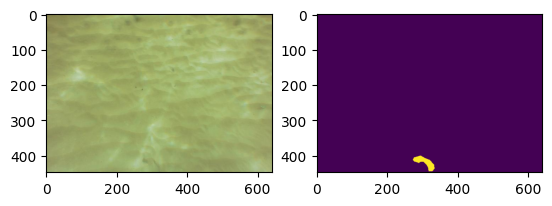

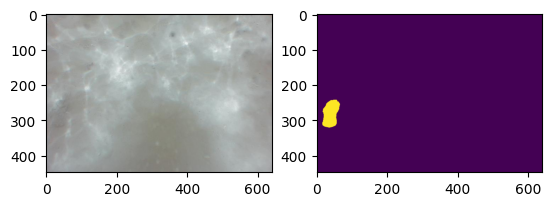

In [ ]:
# lets look at some samples

sample = train_dataset[0]
plt.subplot(1, 2, 1)
# for visualization we have to transpose back to HWC
plt.imshow(sample["image"].permute(1, 2, 0))
plt.subplot(1, 2, 2)
# for visualization we have to remove 3rd dimension of mask
plt.imshow(sample["mask"].squeeze())
plt.show()

sample = valid_dataset[0]
plt.subplot(1, 2, 1)
# for visualization we have to transpose back to HWC
plt.imshow(sample["image"].permute(1, 2, 0))
plt.subplot(1, 2, 2)
# for visualization we have to remove 3rd dimension of mask
plt.imshow(sample["mask"].squeeze())
plt.show()


## Model

In [ ]:
# Some training hyperparameters
EPOCHS = 12
T_MAX = EPOCHS * len(train_dataloader)
OUT_CLASSES = 1

In [ ]:
class ReefModel(pl.LightningModule):
    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch,
            encoder_name=encoder_name,
            in_channels=in_channels,
            classes=out_classes,
            **kwargs,
        )
        # Add dropout to reduce overfitting
        self.dropout = nn.Dropout2d(p=0.2)
        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # Cross entropy to match previous code
        self.loss_fn = nn.BCEWithLogitsLoss()

        # initialize step metics
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []

        # Initialize tracking variables
        self.best_val_iou = 0.0
        self.patience_counter = 0

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        features = self.model.encoder(image)

        # Apply dropout to encoder features during training
        if self.training:
            features = [self.dropout(feature) if i > 0 else feature for i, feature in enumerate(features)]

        decoder_output = self.model.decoder(features)
        masks = self.model.segmentation_head(decoder_output)

        return masks

    def shared_step(self, batch, stage):  # Added batch_idx parameter with default value
        image = batch["image"]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32,
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)

        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(
            pred_mask.long(), mask.long(), mode="binary"
        )


        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        losses = torch.tensor([x["loss"].item() for x in outputs])

        # per image IoU means that we first calculate IoU score for each image
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(
            tp, fp, fn, tn, reduction="micro-imagewise", zero_division=0.0
        )

        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset
        # with "empty" images (images without target class) a large gap could be observed.
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro", zero_division=0.0)
        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
            f"{stage}_loss": losses.mean(),
        }

        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch):
        train_loss_info = self.shared_step(batch, "train")
        # append the metics of each step to the
        self.training_step_outputs.append(train_loss_info)
        return train_loss_info

    def on_train_epoch_end(self):
        self.shared_epoch_end(self.training_step_outputs, "train")
        # empty set output list
        self.training_step_outputs.clear()
        return

    def validation_step(self, batch):
        valid_loss_info = self.shared_step(batch, "valid")
        self.validation_step_outputs.append(valid_loss_info)
        return valid_loss_info

    def on_validation_epoch_end(self):
        self.shared_epoch_end(self.validation_step_outputs, "valid")
        self.validation_step_outputs.clear()
        return

    def test_step(self, batch, batch_idx):
        test_loss_info = self.shared_step(batch, "test")
        self.test_step_outputs.append(test_loss_info)
        return test_loss_info

    def on_test_epoch_end(self):
        self.shared_epoch_end(self.test_step_outputs, "test")
        # empty set output list
        self.test_step_outputs.clear()
        return

    def configure_optimizers(self):
        # Add weight decay to reduce overfitting
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=1e-4,  # Lower initial learning rate
            weight_decay=1e-2  # Add weight decay
        )

        # Modified learning rate scheduler
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='max',
            factor=0.5,
            patience=5,
            verbose=True
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "valid_dataset_iou",  # Monitor validation IoU
                "interval": "epoch",
                "frequency": 1,
            },
        }

In [ ]:
model = ReefModel("Unet", "resnet50", in_channels=3, out_classes=1)

## Training

In [ ]:
!pip install lightning[extra]
from pytorch_lightning.loggers import CSVLogger

csv_logger = CSVLogger("logs/", name="reef_model")

# Create callbacks
early_stopping = pl.callbacks.EarlyStopping(
    monitor='valid_dataset_iou',
    mode='max',
    patience=10,
    verbose=True
)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='valid_dataset_iou',
    mode='max',
    save_top_k=1,
    filename='UNet_50_{epoch}-{valid_dataset_iou:.4f}'
)

lr_monitor = pl.callbacks.LearningRateMonitor(logging_interval='step')

# Create trainer
trainer = pl.Trainer(
    max_epochs=EPOCHS,
    callbacks=[early_stopping, checkpoint_callback, lr_monitor],
    logger=csv_logger,
    gradient_clip_val=0.5,
)

# Start training
trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=valid_dataloader,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | Unet              | 32.5 M | train
1 | dropout | Dropout2d         | 0      | train
2 | loss_fn | BCEWithLogitsLoss | 0      | train
------------------------------------------------------
32.5 M    Trainable params
0         Non-trainable params
32.5 M    Total params
130.084   Total estimated model params size (MB)
225       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_dataset_iou improved. New best score: 0.660


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_dataset_iou improved by 0.069 >= min_delta = 0.0. New best score: 0.729


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_dataset_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.730


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_dataset_iou improved by 0.015 >= min_delta = 0.0. New best score: 0.745


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_dataset_iou improved by 0.013 >= min_delta = 0.0. New best score: 0.758


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_dataset_iou improved by 0.010 >= min_delta = 0.0. New best score: 0.768


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_dataset_iou improved by 0.005 >= min_delta = 0.0. New best score: 0.773


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_dataset_iou improved by 0.004 >= min_delta = 0.0. New best score: 0.778


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_dataset_iou improved by 0.005 >= min_delta = 0.0. New best score: 0.783
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=12` reached.


## Validation and test metrics

In [ ]:
# run validation dataset
valid_metrics = trainer.validate(model, dataloaders=valid_dataloader, verbose=False)
print(valid_metrics)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

[{'valid_per_image_iou': 0.6043691635131836, 'valid_dataset_iou': 0.7827132344245911, 'valid_loss': 0.016318662092089653}]


# Result visualization

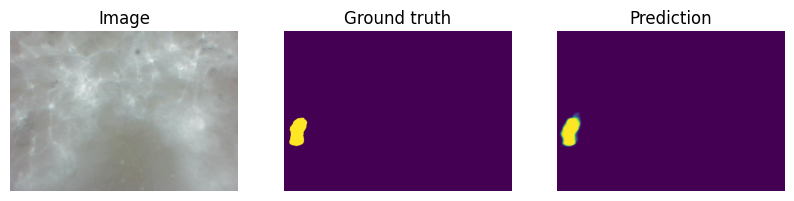

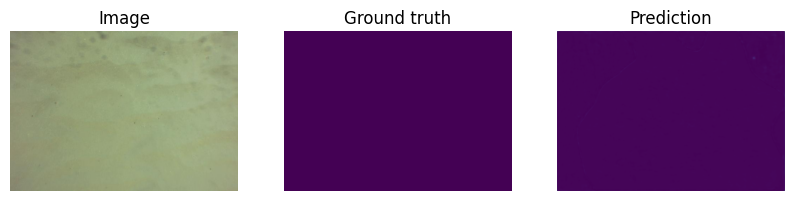

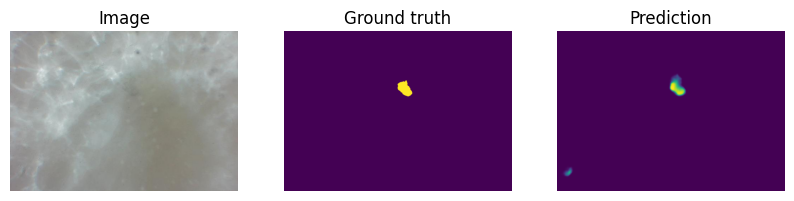

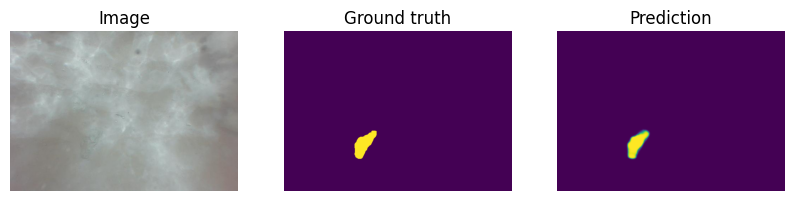

In [ ]:
batch = next(iter(valid_dataloader))
with torch.no_grad():
    model.eval()
    logits = model(batch["image"])
pr_masks = logits.sigmoid()
for idx, (image, gt_mask, pr_mask) in enumerate(
    zip(batch["image"], batch["mask"], pr_masks)
):
    if idx <= 4:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(image.numpy().transpose(1, 2, 0))
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.numpy().squeeze())
        plt.title("Ground truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pr_mask.numpy().squeeze())
        plt.title("Prediction")
        plt.axis("off")
        plt.show()
    else:
        break

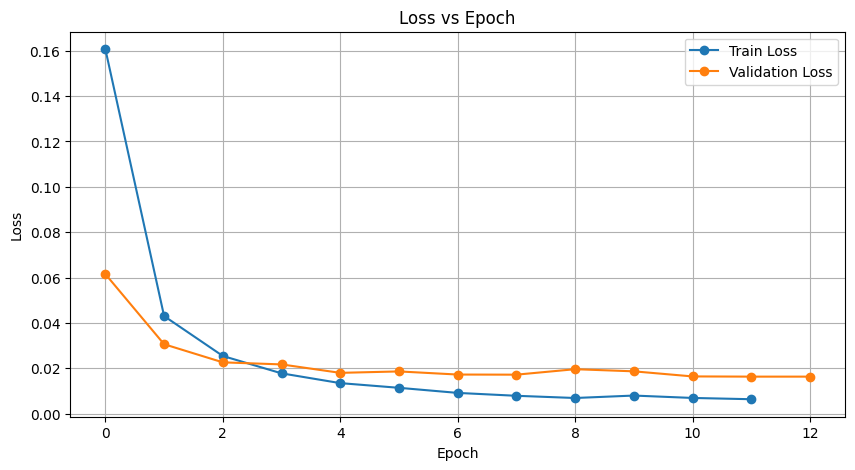

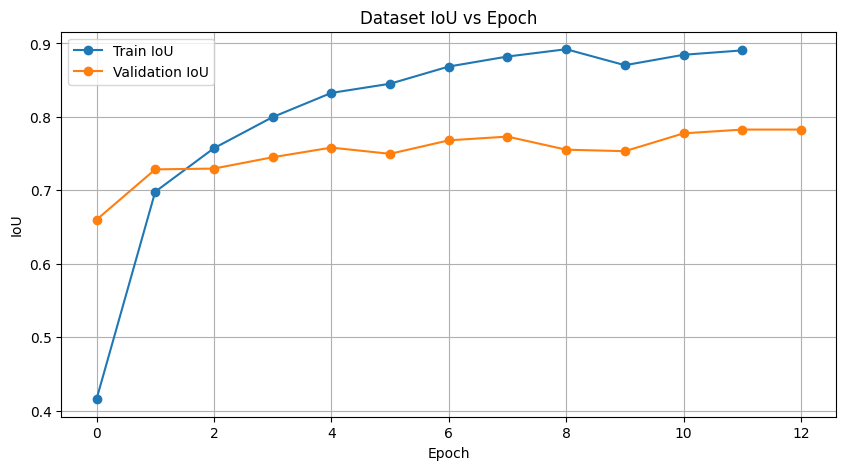

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV
df = pd.read_csv("logs/reef_model/version_2/metrics.csv")

# Only keep rows that have non-null train or val loss
df = df[df["train_loss"].notna() | df["valid_loss"].notna()]

# Group by epoch and aggregate (take max to preserve non-NaNs)
epoch_df = df.groupby("epoch").agg({
    "train_loss": "max",
    "valid_loss": "max",
    "train_dataset_iou": "max",
    "valid_dataset_iou": "max",
    "train_per_image_iou": "max",
    "valid_per_image_iou": "max"
}).reset_index()

# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(epoch_df["epoch"], epoch_df["train_loss"], label="Train Loss", marker='o')
plt.plot(epoch_df["epoch"], epoch_df["valid_loss"], label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epoch_df["epoch"], epoch_df["train_dataset_iou"], label="Train IoU", marker='o')
plt.plot(epoch_df["epoch"], epoch_df["valid_dataset_iou"], label="Validation IoU", marker='o')
plt.xlabel("Epoch")
plt.ylabel("IoU")
plt.title("Dataset IoU vs Epoch")
plt.legend()
plt.grid(True)
plt.show()